# MLOps Zoomcamp Homework 1

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

import pickle

## Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

In [2]:
df = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
print(f'There are {df.shape[0]} records in the data for January')

There are 1154112 records in the data for January


## Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [3]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [4]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

We've confirmed our pickup and drop-off variables are datetimes, so we don't have to convert the data type and can continue on to creating our duration variable.

In [5]:
df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
df['duration'] = df['duration'].apply(lambda ts: ts.total_seconds() / 60)

In [6]:
duration_summary = df['duration'].describe()
print(f"The average trip duration in January is {duration_summary['mean']:.2f}")

The average trip duration in January is 19.17


## Data Preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [7]:
duration_summary = df['duration'].describe(percentiles=[.95, .98, .99])
duration_summary.apply('{0:.2f}'.format)

count    1154112.00
mean          19.17
std          398.69
min            0.02
50%           13.40
95%           47.25
98%           66.13
99%           90.30
max       423371.05
Name: duration, dtype: object

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

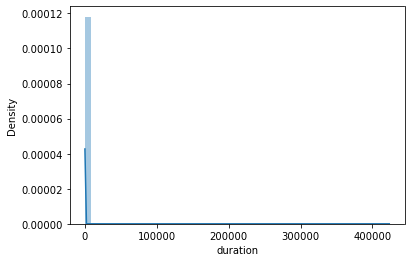

In [8]:
sns.distplot(df['duration'])

In [9]:
count_old = df.shape[0]
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
count_new = df.shape[0]

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

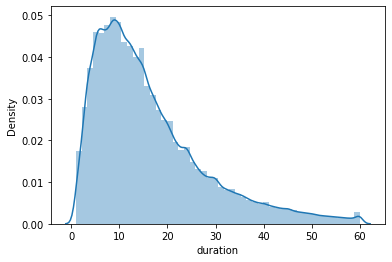

In [10]:
sns.distplot(df['duration'])

In [11]:
print(f'We dropped {count_old - count_new} records from our dataset.')

We dropped 44286 records from our dataset.


## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [12]:
df['PUlocationID'].fillna(value=-1, inplace=True)
df['DOlocationID'].fillna(value=-1, inplace=True)

In [13]:
missing_PUID = df['PUlocationID'].value_counts(normalize=True)
missing_PUID.apply('{0:.3f}'.format)

-1.0      0.835
 221.0    0.008
 206.0    0.006
 129.0    0.005
 115.0    0.004
          ...  
 111.0    0.000
 27.0     0.000
 34.0     0.000
 2.0      0.000
 110.0    0.000
Name: PUlocationID, Length: 262, dtype: object

83.5% of pickup location IDs are missing.

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries
- Fit a dictionary vectorizer
- Get a feature matrix from it
- What's the dimensionality of this matrix? (The number of columns).

In [14]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

dv = DictVectorizer()

train_dicts = df[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [15]:
print(X_train.shape[1])
print(len(dv.feature_names_))

525
525


The dimensionality of our feature matrix is 525. This can be verified by checking the number of columns in `X_train` or the length of `dv.feature_names_`

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters
- Calculate the RMSE of the model on the training data
- What's the RMSE on train?

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

train_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'Using a plain linear regression model, we achieve an RMSE of {train_rmse:.2f} when predicting on the training data')

Using a plain linear regression model, we achieve an RMSE of 10.53 when predicting on the training data


## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

In [18]:
def read_dataframe(filename, categorical):
    """Read in dataset and apply preprocessing steps"""

    df = pd.read_parquet(filename)

    df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
    df['duration'] = df['duration'].apply(lambda ts: ts.total_seconds() / 60)

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    df['PUlocationID'].fillna(value=-1, inplace=True)
    df['DOlocationID'].fillna(value=-1, inplace=True)

    df[categorical] = df[categorical].astype(str)

    return df

In [19]:
categorical = ['PUlocationID', 'DOlocationID']
df_val = read_dataframe('./data/fhv_tripdata_2021-02.parquet', categorical)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
y_val = df_val[target].values
y_pred = lr.predict(X_val)

val_rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f'Applying the model to our validation data, we achieve an RMSE of {val_rmse:.2f}')

Applying the model to our validation data, we achieve an RMSE of 11.01
